In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib isodate

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# display inline plots
%matplotlib inline

In [4]:
# Load dataset (update path if needed)
path = "youtube_channel_real_performance_analytics (2).csv"  # change if your filename differs
assert os.path.exists(path), f"File not found: {path}"
df = pd.read_csv(path)
print("Loaded:", path, "Shape:", df.shape)
df.head()

Loaded: youtube_channel_real_performance_analytics (2).csv Shape: (364, 70)


,ID,Video Duration,Video Publish Time,Days Since Publish,Day,Month,Year,Day of Week,Revenue per 1000 Views (USD),Monetized Playbacks (Estimate),...,Watched (Not Skipped) (%),Feed Impressions,Average View Percentage (%),Average View Duration,Views,Watch Time (hours),Subscribers,Estimated Revenue (USD),Impressions,Video Thumbnail CTR (%)
0,0,201.0,2016-06-02 00:00:00,0,2,6,2016,Thursday,0.024,723.0,...,0.0,0.0,40.38,81.0,23531.0,533.1636,51.0,0.561,41118.0,27.66
1,1,391.0,2016-06-10 00:00:00,8,10,6,2016,Friday,0.056,727.0,...,0.0,0.0,39.85,156.0,11478.0,500.5628,33.0,0.648,41627.0,5.85
2,2,133.0,2016-06-14 00:00:00,4,14,6,2016,Tuesday,0.014,76.0,...,0.0,0.0,30.88,41.0,6153.0,70.7287,8.0,0.089,38713.0,7.07
3,3,14.0,2016-06-29 00:00:00,15,29,6,2016,Wednesday,0.004,18.0,...,0.0,0.0,103.05,14.0,4398.0,17.6251,2.0,0.017,35245.0,5.60
4,4,45.0,2016-07-01 00:00:00,2,1,7,2016,Friday,0.000,0.0,...,0.0,0.0,55.70,25.0,14659.0,104.3341,28.0,0.000,46218.0,8.62


In [5]:
def find_col(df, candidates):
    """Return the first matching column name from candidates (exact then substring)."""
    cols = df.columns.tolist()
    for c in candidates:
        for col in cols:
            if col.strip().lower() == c.strip().lower():
                return col
    for c in candidates:
        for col in cols:
            if c.strip().lower() in col.strip().lower():
                return col
    return None

print("Columns count:", len(df.columns))
display(df.info())
display(df.columns.tolist()[:50])

Columns count: 70
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  364 non-null    int64  
 1   Video Duration                      364 non-null    float64
 2   Video Publish Time                  364 non-null    object 
 3   Days Since Publish                  364 non-null    int64  
 4   Day                                 364 non-null    int64  
 5   Month                               364 non-null    int64  
 6   Year                                364 non-null    int64  
 7   Day of Week                         364 non-null    object 
 8   Revenue per 1000 Views (USD)        364 non-null    float64
 9   Monetized Playbacks (Estimate)      364 non-null    float64
 10  Playback-Based CPM (USD)            364 non-null    float64
 11  CPM (USD)                  

None

['ID',
 'Video Duration',
 'Video Publish Time',
 'Days Since Publish',
 'Day',
 'Month',
 'Year',
 'Day of Week',
 'Revenue per 1000 Views (USD)',
 'Monetized Playbacks (Estimate)',
 'Playback-Based CPM (USD)',
 'CPM (USD)',
 'Ad Impressions',
 'Estimated AdSense Revenue (USD)',
 'DoubleClick Revenue (USD)',
 'YouTube Ads Revenue (USD)',
 'Watch Page Ads Revenue (USD)',
 'YouTube\xa0Premium (USD)',
 'Transaction Revenue (USD)',
 'Transactions',
 'Revenue from Transactions (USD)',
 'Reactions',
 'Chat Messages Count',
 'Reminders Set',
 'Stream Hours',
 'Remix Views',
 'Remix Count',
 'Subscribers from Posts',
 'New Comments',
 'Shares',
 'Like Rate (%)',
 'Dislikes',
 'Likes',
 'Unsubscribes',
 'New Subscribers',
 'Returned Items (USD)',
 'Unconfirmed Commissions (USD)',
 'Approved Commissions (USD)',
 'Orders',
 'Total Sales Volume (USD)',
 'End Screen Click-Through Rate (%)',
 'End Screen Impressions',
 'End Screen Clicks',
 'Teaser Click-Through Rate (%)',
 'Teaser Impressions',
 '

In [6]:
# Convert publish time to datetime (if exists)
pub_col = find_col(df, ["Video Publish Time", "VideoPublishTime", "Publish Time"])
if pub_col:
    df[pub_col] = pd.to_datetime(df[pub_col], errors='coerce')
    print(f"Converted {pub_col} → datetime, nulls:", df[pub_col].isnull().sum())


Converted Video Publish Time → datetime, nulls: 0


In [7]:
import isodate  # installed in Step 0
dur_col = find_col(df, ["Video Duration", "Duration", "VideoDuration"])
if dur_col:
    if df[dur_col].dtype == object:
        def parse_dur_safe(x):
            try:
                return isodate.parse_duration(x).total_seconds()
            except Exception:
                try:
                    return float(x)
                except Exception:
                    return np.nan
        df["Video_Duration_seconds"] = df[dur_col].apply(parse_dur_safe)
    else:
        df["Video_Duration_seconds"] = pd.to_numeric(df[dur_col], errors='coerce')
    print("Video_Duration_seconds created. Nulls:", df["Video_Duration_seconds"].isnull().sum())
else:
    print("No duration-like column found.")

Video_Duration_seconds created. Nulls: 0


In [8]:
# Identify main columns
est_rev_col = find_col(df, ["Estimated Revenue (USD)", "EstimatedRevenue", "Estimated Revenue"])
views_col = find_col(df, ["Views"])
likes_col = find_col(df, ["Likes"])
shares_col = find_col(df, ["Shares"])
comments_col = find_col(df, ["Comments", "New Comments"])
subs_col = find_col(df, ["Subscribers"])
impr_col = find_col(df, ["Impressions"])
ctr_col = find_col(df, ["Video Thumbnail CTR", "CTR", "Thumbnail CTR"])

print("Detected columns:")
print("Estimated revenue:", est_rev_col)
print("Views:", views_col)
print("Likes:", likes_col)
print("Shares:", shares_col)
print("Comments:", comments_col)
print("Subscribers:", subs_col)
print("Impressions:", impr_col)
print("CTR:", ctr_col)

Detected columns:
Estimated revenue: Estimated Revenue (USD)
Views: Views
Likes: Likes
Shares: Shares
Comments: New Comments
Subscribers: Subscribers
Impressions: Impressions
CTR: Video Thumbnail CTR (%)


In [9]:
# Missingness overview
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(40))

# Drop columns with > 50% missing (optional)
thresh = 0.5 * len(df)
cols_before = df.shape[1]
df = df.dropna(axis=1, thresh=thresh)
print("Dropped cols with >50% missing. New shape:", df.shape, "Dropped:", cols_before - df.shape[1])

# For numeric columns, fill remaining NaNs with 0 or median (choose what makes sense):
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(0)

ID                                    0
Teaser Clicks                         0
Playlist Watch Time (hours)           0
Playlist Views                        0
Views per Playlist Start              0
Card Clicks                           0
Card Impressions                      0
Card Click-Through Rate (%)           0
Teaser Impressions                    0
Clip Views                            0
Teaser Click-Through Rate (%)         0
End Screen Clicks                     0
End Screen Impressions                0
End Screen Click-Through Rate (%)     0
Total Sales Volume (USD)              0
Orders                                0
Clip Watch Time (hours)               0
YouTube Premium Watch Time (hours)    0
Unconfirmed Commissions (USD)         0
Average View Duration                 0
Video Thumbnail CTR (%)               0
Impressions                           0
Estimated Revenue (USD)               0
Subscribers                           0
Watch Time (hours)                    0


Dropped cols with >50% missing. New shape: (364, 71) Dropped: 0


In [10]:
#Feature engineering
vcol = views_col
likes = likes_col; shares = shares_col; comments = comments_col
df['Engagement'] = 0
if likes: df['Engagement'] += df[likes].fillna(0)
if shares: df['Engagement'] += df[shares].fillna(0)
if comments: df['Engagement'] += df[comments].fillna(0)

# Engagement rate (%) = (likes+shares+comments) / views * 100
if vcol:
    df['Engagement_Rate_pct'] = df['Engagement'] / df[vcol].replace({0: np.nan}) * 100
    df['Revenue_per_View'] = df[est_rev_col].fillna(0) / df[vcol].replace({0: np.nan})
else:
    df['Engagement_Rate_pct'] = df['Engagement']  # fallback

# quick look
display(df[['Engagement', 'Engagement_Rate_pct', 'Revenue_per_View']].head())

,Engagement,Engagement_Rate_pct,Revenue_per_View
0,1027.0,4.364455,0.000024
1,362.0,3.153860,0.000056
2,243.0,3.949293,0.000014
3,239.0,5.434288,0.000004
4,659.0,4.495532,0.000000


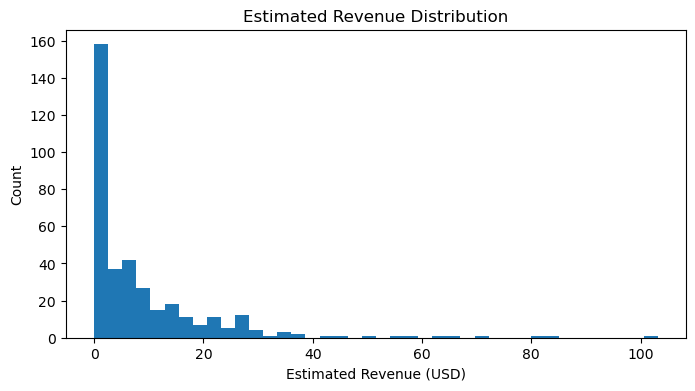

In [11]:
#  Distribution of estimated revenue
if est_rev_col:
    plt.figure(figsize=(8,4))
    plt.hist(df[est_rev_col].dropna(), bins=40)
    plt.title("Estimated Revenue Distribution")
    plt.xlabel("Estimated Revenue (USD)")
    plt.ylabel("Count")
    plt.show()

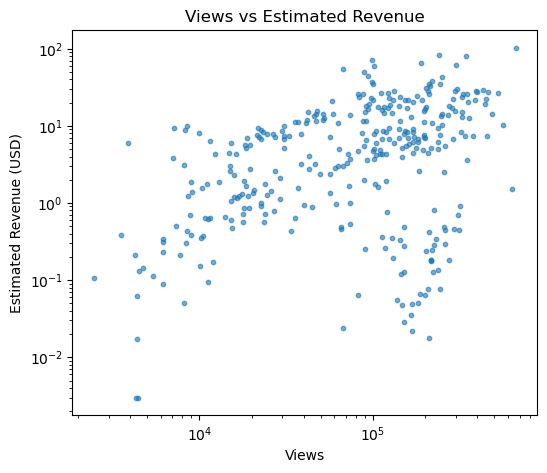

In [12]:
#  Views vs Revenue scatter
if vcol and est_rev_col:
    plt.figure(figsize=(6,5))
    plt.scatter(df[vcol], df[est_rev_col], alpha=0.6, s=10)
    plt.xscale('log') if df[vcol].max() / max(df[vcol].min(),1) > 100 else None
    plt.yscale('log') if df[est_rev_col].max() / max(df[est_rev_col].min(),1) > 100 else None
    plt.title("Views vs Estimated Revenue")
    plt.xlabel("Views")
    plt.ylabel("Estimated Revenue (USD)")
    plt.show()

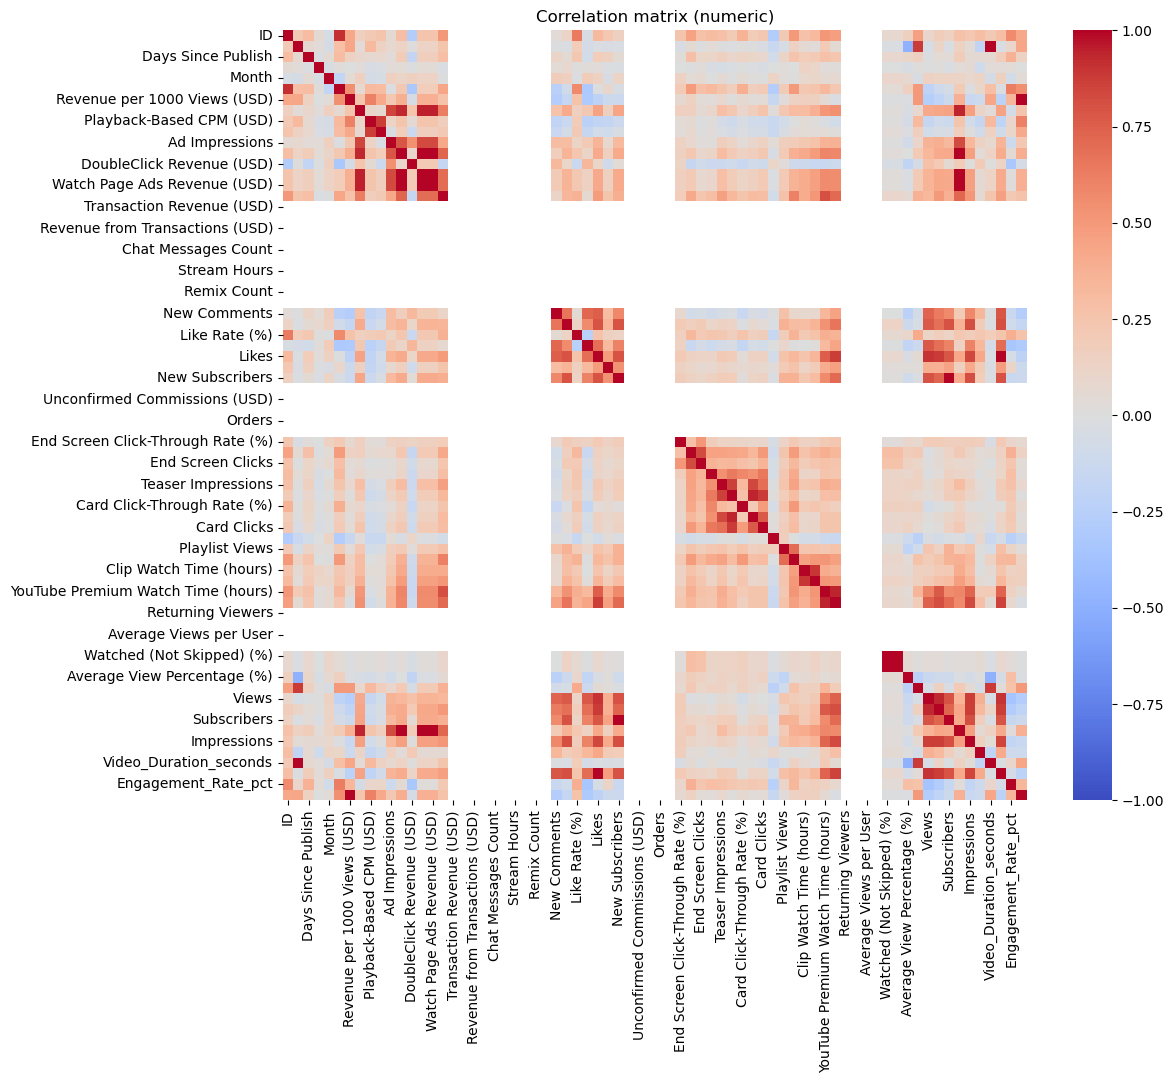

In [13]:
#Correlation heatmap (numeric)
plt.figure(figsize=(12,10))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=1, vmin=-1)
plt.title("Correlation matrix (numeric)")
plt.show()

In [14]:
#Leakage check by string and correlation
numeric = df.select_dtypes(include=[np.number]).copy()
target = est_rev_col
if target is None:
    raise ValueError("Target column not found. Please update est_rev_col in Step 4.")

# 1) drop columns whose name contains 'revenue' or 'estimated' (likely leakage)
leak_by_name = [c for c in numeric.columns if 'revenue' in c.lower() or 'estimated' in c.lower()]
print("Columns with 'revenue' name (dropping):", leak_by_name)

# 2) high-correlation features (corr > 0.95)
corr_with_target = numeric.corr()[target].abs().sort_values(ascending=False)
high_corr = corr_with_target[corr_with_target > 0.95].index.tolist()
print("Highly correlated features (>0.95):", high_corr)

# Combine and exclude target
leak_candidates = list(set(leak_by_name + [c for c in high_corr if c != target]))
print("Leak candidates to remove from features:", leak_candidates)

Columns with 'revenue' name (dropping): ['Revenue per 1000 Views (USD)', 'Estimated AdSense Revenue (USD)', 'DoubleClick Revenue (USD)', 'YouTube Ads Revenue (USD)', 'Watch Page Ads Revenue (USD)', 'Transaction Revenue (USD)', 'Revenue from Transactions (USD)', 'Estimated Revenue (USD)', 'Revenue_per_View']
Highly correlated features (>0.95): ['Estimated Revenue (USD)', 'Watch Page Ads Revenue (USD)', 'YouTube Ads Revenue (USD)', 'Estimated AdSense Revenue (USD)']
Leak candidates to remove from features: ['YouTube Ads Revenue (USD)', 'Transaction Revenue (USD)', 'Revenue_per_View', 'Watch Page Ads Revenue (USD)', 'Revenue from Transactions (USD)', 'Estimated AdSense Revenue (USD)', 'DoubleClick Revenue (USD)', 'Revenue per 1000 Views (USD)', 'Estimated Revenue (USD)']


In [15]:
# Prepare features and target
id_cols = [c for c in df.columns if c.lower() in ('id', 'video id', 'videoid', 'name', 'title')]
date_cols = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower()]

# start from numeric columns
X = numeric.drop(columns=[target] + leak_candidates + id_cols + date_cols, errors='ignore').copy()
y = numeric[target].copy()

# optionally remove columns with extremely low variance
low_var = [c for c in X.columns if X[c].nunique() <= 1]
X = X.drop(columns=low_var, errors='ignore')

print("Final feature matrix shape:", X.shape)
print("Example feature columns:", X.columns[:20].tolist())

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Final feature matrix shape: (364, 41)
Example feature columns: ['Video Duration', 'Days Since Publish', 'Day', 'Month', 'Year', 'Monetized Playbacks (Estimate)', 'Playback-Based CPM (USD)', 'CPM (USD)', 'Ad Impressions', 'YouTube\xa0Premium (USD)', 'New Comments', 'Shares', 'Like Rate (%)', 'Dislikes', 'Likes', 'Unsubscribes', 'New Subscribers', 'End Screen Click-Through Rate (%)', 'End Screen Impressions', 'End Screen Clicks']


In [16]:
#Train baseline model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Baseline RandomForest -> RMSE: {rmse:.4f}, R2: {r2:.4f}")

Baseline RandomForest -> RMSE: 2.6273, R2: 0.9207


In [17]:
#Cross-validation (R2)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
print("5-fold CV R2 scores:", cv_scores)
print("Mean R2:", cv_scores.mean())

5-fold CV R2 scores: [-1.15202882 -0.00164365  0.94146748  0.75855073  0.90918961]
Mean R2: 0.29110707123835144


In [18]:
#Randomized hyperparameter search (example)
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_

# evaluate
y_pred_best = best_rf.predict(X_test)
print("Tuned model -> RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)), "R2:", r2_score(y_test, y_pred_best))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Tuned model -> RMSE: 2.7331449617324197 R2: 0.9142023727190063


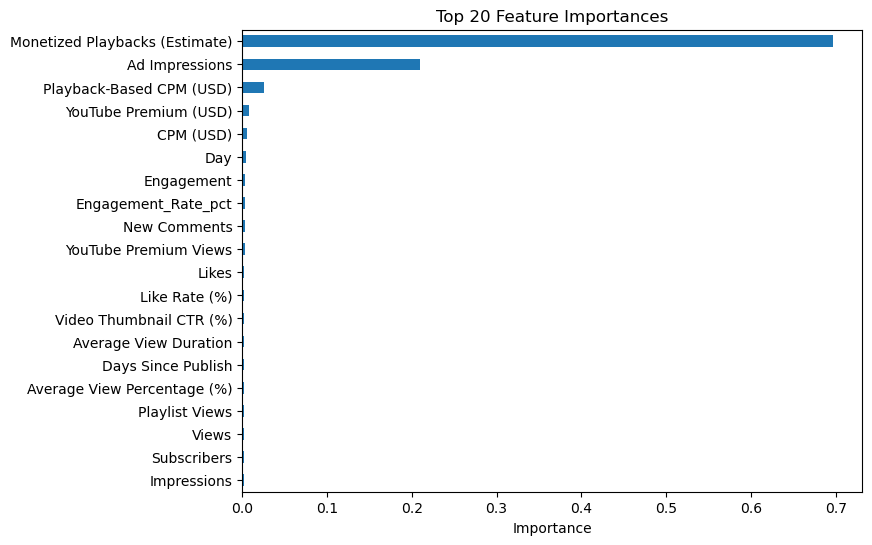

Monetized Playbacks (Estimate)    0.696261
Ad Impressions                    0.209917
Playback-Based CPM (USD)          0.025253
YouTube Premium (USD)             0.008042
CPM (USD)                         0.005180
Day                               0.005002
Engagement                        0.003685
Engagement_Rate_pct               0.003552
New Comments                      0.003423
YouTube Premium Views             0.002940
Likes                             0.002585
Like Rate (%)                     0.002397
Video Thumbnail CTR (%)           0.002380
Average View Duration             0.002320
Days Since Publish                0.002200
Average View Percentage (%)       0.001824
Playlist Views                    0.001725
Views                             0.001714
Subscribers                       0.001632
Impressions                       0.001622
dtype: float64

In [19]:
model_for_importance = best_rf if 'best_rf' in locals() else rf
importances = pd.Series(model_for_importance.feature_importances_, index=X.columns).sort_values(ascending=False)
top20 = importances.head(20)
plt.figure(figsize=(8,6))
top20[::-1].plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()

# display top 20 as table
display(top20.head(20))

In [20]:
final_model = best_rf if 'best_rf' in locals() else rf
model_path = "youtube_revenue_predictor.pkl"
joblib.dump(final_model, model_path)
print("Saved model to", model_path)

Saved model to youtube_revenue_predictor.pkl


In [22]:
!pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 3.6 MB/s eta 0:00:00


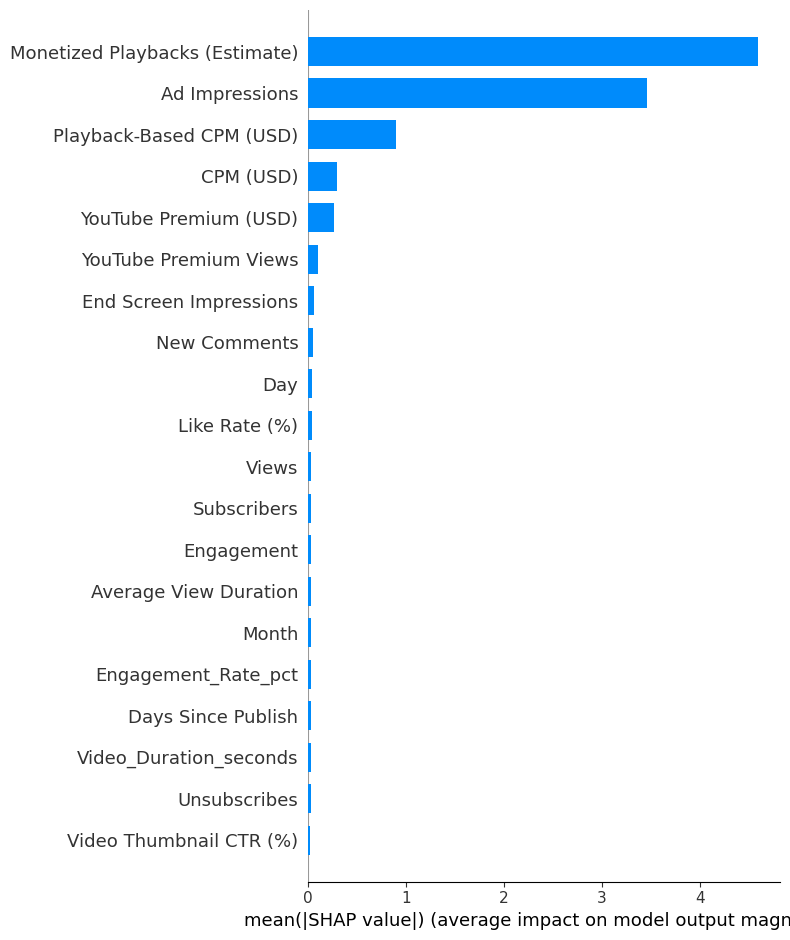

In [23]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [24]:

def predict_estimated_revenue(row_or_df):
    """row_or_df: pandas Series or DataFrame with same feature columns as X"""
    data = row_or_df.copy()
    if isinstance(row_or_df, pd.Series):
        data = row_or_df.to_frame().T
    data = data[X.columns]  # align columns - this will raise if missing columns
    preds = final_model.predict(data)
    return preds

# Example usage: predict for first test row
print("Predicted:", predict_estimated_revenue(X_test.iloc[[0]]))
print("Actual:", y_test.iloc[0])

Predicted: [0.001435]
Actual: 0.0
